In [1]:
#!pip install git+https://github.com/qubvel/segmentation_models

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import cv2
from tensorflow import keras
import numpy as np
import PIL
from IPython.display import Image, display
from PIL import ImageOps
import random
import re
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [3]:
sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [4]:
def bgr_to_rgb(img):
    b,g,r = cv2.split(img)
    return cv2.merge([r,g,b])

In [5]:
def load_all_imgs(path, img_size, mode):
    imgs = []
    files = os.listdir(path)
    files.sort()
    print(f'\n{path} found {len(files)} img to load')
    for index, file in enumerate(files):
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path, mode)
        
        if mode == 0:
            img = np.expand_dims(img, 2)
        
        if mode == 1:
            img = bgr_to_rgb(img)
        img = cv2.resize(img, img_size)
        img = img / 255.
        imgs.append(img)
        if index % 100 == 0:
            print(f'\n[{index}]:', end='')
        else:
            print("|", end='')
    return np.array(imgs)

In [6]:
img_size = (224, 224)
img_shape = (224,224,3)
input_dir = "../dataset/segmentation/all_seg/"
target_dir = "../dataset/segmentation/annotation/all/"
num_classes = 1
batch_size = 10
epochs = 100

In [7]:
# Load images
trainImgs = load_all_imgs(input_dir,img_size, 1)
validImgs = load_all_imgs(target_dir,img_size, 0)


../dataset/segmentation/all_seg/ found 120 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||
../dataset/segmentation/annotation/all/ found 120 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||

In [8]:
img_to_test = int(len(trainImgs) * 0.8)
x_train = trainImgs[0:img_to_test]
y_train = validImgs[0:img_to_test]
x_val = trainImgs[img_to_test:]
y_val = validImgs[img_to_test:]
validation_data = (x_val, y_val)
print("ImgToTest:",img_to_test)
print("Validation_data_size:", len(validation_data[0]))

ImgToTest: 96
Validation_data_size: 24


In [9]:
keras.backend.clear_session()

In [10]:
model = sm.FPN(input_shape=img_shape, classes=1, encoder_freeze=True)
model.compile('Adam',loss=sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score])

2021-11-24 20:38:36.180851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 20:38:36.184762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 20:38:36.185193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 20:38:36.185895: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [11]:
pred = model.predict(x_train)

2021-11-24 20:38:37.170822: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-24 20:38:37.689636: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-11-24 20:38:38.701254: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-24 20:38:38.701331: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-24 20:38:38.802126: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying t

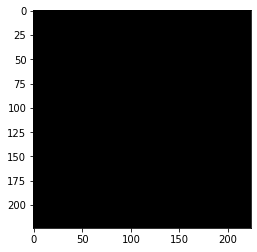

In [19]:
plt.imshow(pred[80], cmap='gray')

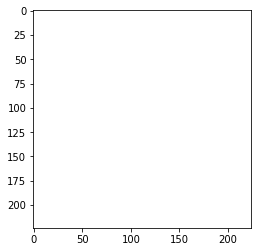

In [13]:
from matplotlib.colors import NoNorm
predict_img = pred[80]
predict_img[predict_img > 0.5] = 1
predict_img[predict_img <= 0.5] = 0

plt.imshow(predict_img, cmap='gray', norm=NoNorm())

In [14]:
model.fit(x_train, y_train, batch_size=batch_size,epochs=epochs, validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 26s 2s/step - loss: 10.8724 - iou_score: 0.3304 - val_loss: 11.8343 - val_iou_score: 0.2613
Epoch 2/100
10/10 [==============================] - 6s 640ms/step - loss: 10.8724 - iou_score: 0.3314 - val_loss: 11.8343 - val_iou_score: 0.2613
Epoch 3/100
10/10 [==============================] - 6s 638ms/step - loss: 10.8724 - iou_score: 0.3304 - val_loss: 11.8343 - val_iou_score: 0.2613
Epoch 4/100
10/10 [==============================] - 6s 631ms/step - loss: 10.8724 - iou_score: 0.3309 - val_loss: 11.8343 - val_iou_score: 0.2613
Epoch 5/100
10/10 [==============================] - 6s 639ms/step - loss: 10.8724 - iou_score: 0.3319 - val_loss: 11.8343 - val_iou_score: 0.2613
Epoch 6/100
10/10 [==============================] - 6s 634ms/step - loss: 10.8724 - iou_score: 0.3304 - val_loss: 11.8343 - val_iou_score: 0.2613
Epoch 7/100
10/10 [==============================] - 6s 640ms/step - loss: 10.8724 - iou_score: 0.3303 - val_loss: 11.83

10/10 [==============================] - 6s 636ms/step - loss: 10.8724 - iou_score: 0.3306 - val_loss: 11.8343 - val_iou_score: 0.2613
Epoch 57/100
10/10 [==============================] - 6s 630ms/step - loss: 10.8724 - iou_score: 0.3289 - val_loss: 11.8343 - val_iou_score: 0.2613
Epoch 58/100
10/10 [==============================] - 6s 613ms/step - loss: 10.8724 - iou_score: 0.3291 - val_loss: 11.8343 - val_iou_score: 0.2613
Epoch 59/100
10/10 [==============================] - 6s 637ms/step - loss: 10.8724 - iou_score: 0.3331 - val_loss: 11.8343 - val_iou_score: 0.2613
Epoch 60/100
10/10 [==============================] - 6s 640ms/step - loss: 10.8724 - iou_score: 0.3305 - val_loss: 11.8343 - val_iou_score: 0.2613
Epoch 61/100
10/10 [==============================] - 6s 625ms/step - loss: 10.8724 - iou_score: 0.3323 - val_loss: 11.8343 - val_iou_score: 0.2613
Epoch 62/100
10/10 [==============================] - 6s 618ms/step - loss: 10.8724 - iou_score: 0.3313 - val_loss: 11.8343 -

In [15]:
def plot_result(img_pred, original, valid):
    plt.figure(figsize=(10, 10))
    n = 1
    for index, img in enumerate(img_pred):
        for i in range(3):
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.subplot(img_pred.shape[0] , 3, n)
            if i == 0:
                original_img = cv2.resize(original[index], img_size)
                plt.imshow(original_img)
                plt.xlabel("Original ")
            if i == 1:
                result_img = cv2.resize(img, img_size)
                plt.imshow(result_img, cmap=plt.cm.binary)
                plt.xlabel("Result", )
            if i == 2:
                valid_img = cv2.resize(valid[index], img_size)
                plt.imshow(valid_img, cmap=plt.cm.binary)
                plt.xlabel("Expected")
            n += 1


../dataset/segmentation/healthy/ found 30 img to load

[0]:|||||||||||||||||||||||||||||
../dataset/segmentation/annotation/healthy/ found 30 img to load

[0]:|||||||||||||||||||||||||||||

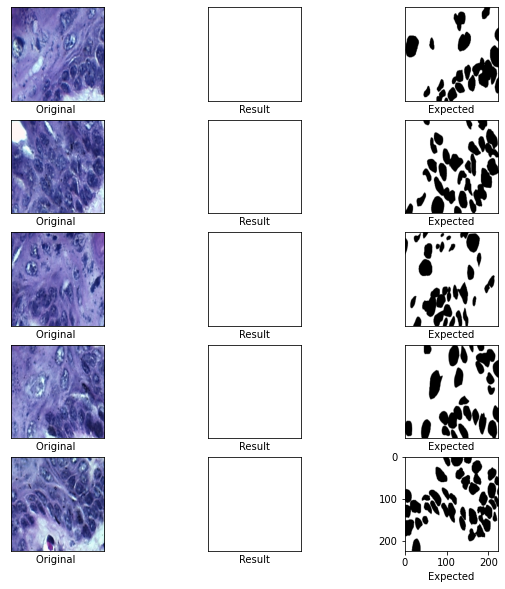

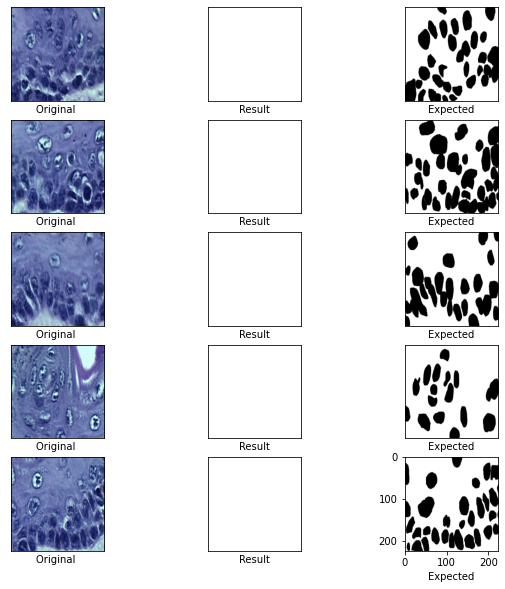

In [16]:
path_healthy_img = '../dataset/segmentation/healthy/'
path_healthy_val = '../dataset/segmentation/annotation/healthy/'

healthy_img = load_all_imgs(path_healthy_img, img_size, 1)
healthy_val = load_all_imgs(path_healthy_val, img_size, 0)
healthy_pred = model.predict(healthy_img)
# ----- Primeiras 5 Imagens -----
plot_result(healthy_pred[:5], healthy_img[:5], healthy_val[:5])
# ----- Ultimas 5 Imagens -----
plot_result(healthy_pred[-5:], healthy_img[-5:], healthy_val[-5:])